In [1]:
import os
import sys
import pandas as pd
from pyspark import SparkContext, sql, SparkConf
import __builtin__
import numpy as np
import matplotlib.pyplot as plt
import pickle

#import pyspark.sql as sparksql
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SparkSession

import seaborn as sb
%matplotlib inline

#-------------------------------
# Importing from other folders, appending the path
sys.path.append('../')
from spark_sessions import start_session, stop_session
print "all imported."

all imported.


/Users/Ahmed/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
spark_configs = (SparkConf()\
            .setAppName("experiment-churn")\
            .set("spark.executor.instances", "10")\
            .set("spark.executor.cores", 2)\
            .set("spark.dynamicAllocation.enabled", "false")\
            .set("spark.shuffle.service.enabled", "false")\
            .set("spark.executor.memory", "500MB"))
#pickle.dump( spark_configs, open( "sparks.txt", "wb" ) )

In [3]:
#----------------
def spark_session(version):
    if version == 0:
        conf = spark_configs
        return conf
    
    elif version == 1:
        spark = SparkSession.builder \
            .master("yarn") \
            .appName("experiment-airbnb") \
            .enableHiveSupport() \
            .getOrCreate()

        return spark

In [4]:
#----------------
def spark_context_sql(sample):
    # Creating "pyspark.sql.context.SQLContext object"
    sqlContext = SQLContext(spark_session(version=1))
    data = sqlContext.read.load(sample,
                    format='com.databricks.spark.csv', 
                    header='true', 
                    inferSchema='true').cache()
        
    return data

def spark_context_txt(sample):
    # Creating "pyspark.context.SparkContext object"
    conf = spark_session(version=0)
    sc = SparkContext.getOrCreate(conf = conf)
    data = sc.textFile(sample)
    #print 'type of context for session v 0:', sc
    
    return data

In [5]:
#----------------
def structure_field(key, item): # item = StringType() ...
    key = str
    item = str
    structure = []
    structure.append(StructField(key, item, True))
        
    return structure

In [6]:
def spark_framing(data, schema):
    # take the schema and convert it to a spark DF
    spark_df = data.map(lambda x: (x, )).toDF(schema)
    
    return spark_df

In [7]:
def panda_framing(sample):
    # Frame the data with panda
    #_panda_framed = pd.read_csv(sample)
    #panda_framed = pd.DataFrame(_panda_framed)
    data = spark_context_sql(sample)
    panda_df = data.sample(False, 0.5, 83).toPandas()
    print panda_df.head()
    
    return panda_df

In [40]:
#----------------
def spark_schema_v0(sample):
    data = spark_context_sql(sample) # we need this to create the keys (data types)
    _keys = data.take(2)
    
    _data = spark_context_txt(sample) # we need this to create the schema
    schemaString = _data.first().replace('"','').replace(' ','')
    _schema = schemaString.split(',')# Creating a schema
    headers = _data.filter(lambda l: "_id" in l) # Headers needs to be an RDD - the string we constructed above will not do the job
    headers.collect()
    _spark_data = _data.subtract(headers)
    spark_data= _spark_data.map(lambda l: l.split(",").replace(' ',''))

    
    print "Found %d columns in your data file \n" % len(_keys[0]) 
    _types = []
    fields = []
    #schem = schemaString.split(',')
    print "Followings are the details of your schema:"
    print "------------------------------------------"
    for key in range(len(_keys[1])) or (type(_keys[1][key]) == None):   
        if (type(_keys[1][key]) == int):
            data_type = IntegerType()
            str_struct = StructField(_schema[key], data_type, True)
            fields.append(str_struct)
            #_types.append((_schema[key], data_type))
            print 'key:', '"'+_schema[key]+'",',',', ' value:', _keys[1][key],',', ' data type:', data_type #, ' value:', _keys[0][key], 
        
        elif (type(_keys[1][key]) == float):
            data_type = FloatType()
            str_struct = StructField(_schema[key], data_type, True)
            fields.append(str_struct)
            #_types.append((_schema[key], data_type))
            print 'key:', '"'+_schema[key]+'",',',',' value:', _keys[1][key],',', ' data type:', data_type #, ' value:', _keys[0][key],
        
        elif (type(_keys[1][key]) == unicode) or (type(_keys[0][key]) == str):
            data_type = StringType()
            str_struct = StructField(_schema[key], data_type, True)
            fields.append(str_struct)
            #_types.append((_schema[key], data_type))
            print 'key:', '"'+_schema[key]+'",',',', ' value:', _keys[1][key], ',', 'data type:', data_type
        
        else:
            data_type = StringType()#TimestampType()
            str_struct = StructField(_schema[key], data_type, True)
            fields.append(str_struct)
            #_types.append((_schema[key], data_type))
            print 'key:', '"'+_schema[key]+'",',',', ' value:', _keys[1][key], ',', 'data type:', data_type
    
    print "------------------------------------------"
    print "Your schema's 'StructField' are:"
    for x in fields:
        print x
        pickle.dump( x, open( "sparks.txt", "ab" ) )
    
    print "------------------------------------------"

    
    # Creating the spark DataFrame:
    conf = spark_session(version=0)
    sc = SparkContext.getOrCreate(conf = conf)
    _spark_data.map(lambda l: tuple(l[:1]) + tuple(l[1].split(','))).map(lambda x: x.split('\t'))
    #print _spark_data
    #rdd = sc.parallelize(_spark_data.map( lambda elem: list(elem)))
    #.map(lambda p: (p[0], p[1].strip()))
    
    schema = StructType(fields)
    spark_df = spark_framing(_spark_data, schema)
    
    return spark_df


In [41]:
sample = "/Users/Ahmed/Documents/Data-Mining/Hadoop/Spark/PySpark/tutorials/airbnb/ds-for-telco-master/data/churn.all"
df = spark_schema_v0(sample)

Found 21 columns in your data file 

Followings are the details of your schema:
------------------------------------------
key: "state", ,  value: OH , data type: StringType
key: "account_length", ,  value: 107.0 ,  data type: FloatType
key: "area_code", ,  value: 415.0 ,  data type: FloatType
key: "phone_number", ,  value:  371-7191 , data type: StringType
key: "intl_plane", ,  value:  no , data type: StringType
key: "voice_mail_plan", ,  value:  yes , data type: StringType
key: "number_vmail_messages", ,  value: 26.0 ,  data type: FloatType
key: "total_day_minutes", ,  value: 161.6 ,  data type: FloatType
key: "total_day_calls", ,  value: 123.0 ,  data type: FloatType
key: "total_day_chare", ,  value: 27.47 ,  data type: FloatType
key: "total_eve_minutes", ,  value: 195.5 ,  data type: FloatType
key: "total_eve_calls", ,  value: 103.0 ,  data type: FloatType
key: "total_eve_charge", ,  value: 16.62 ,  data type: FloatType
key: "total_night_minutes", ,  value: 254.4 ,  data type: Floa

In [42]:
panda_df = panda_framing(sample)
print '\n \n', "DataFrame before replacing NaNs"
print '-'*30
print panda_df.isnull().any(), '\n \n'
#listt = panda_df.columns[panda_df.isnull().any()].tolist()
panda_df.fillna(0, inplace=True)

print 'DataFrame after replacing NaNs with zeros'
print '-'*40
print panda_df.isnull().any()

print '\n \n', "Length of DataFrame: %d" %len(panda_df), 'lines'

  state   account_length   area_code  phone_number  intl_plane  \
0    KS            128.0       415.0      382-4657          no   
1    OH            107.0       415.0      371-7191          no   
2    NJ            137.0       415.0      358-1921          no   
3    OK             75.0       415.0      330-6626         yes   
4    AL            118.0       510.0      391-8027         yes   

   voice_mail_plan   number_vmail_messages   total_day_minutes  \
0              yes                    25.0               265.1   
1              yes                    26.0               161.6   
2               no                     0.0               243.4   
3               no                     0.0               166.7   
4               no                     0.0               223.4   

    total_day_calls   total_day_chare    ...      total_eve_calls  \
0             110.0             45.07    ...                 99.0   
1             123.0             27.47    ...                103.0   

### Data insights

In [51]:
numeric_fetures = ["account_length", "number_vmail_messages", "total_day_minutes",
                "total_day_calls", "total_day_charge", "total_eve_minutes",
                "total_eve_calls", "total_eve_charge", "total_night_minutes",
                "total_night_calls", "total_intl_minutes", "total_intl_calls",
                "total_intl_charge"]

categorical_features = ["state", "international_plan", "voice_mail_plan", "area_code"]

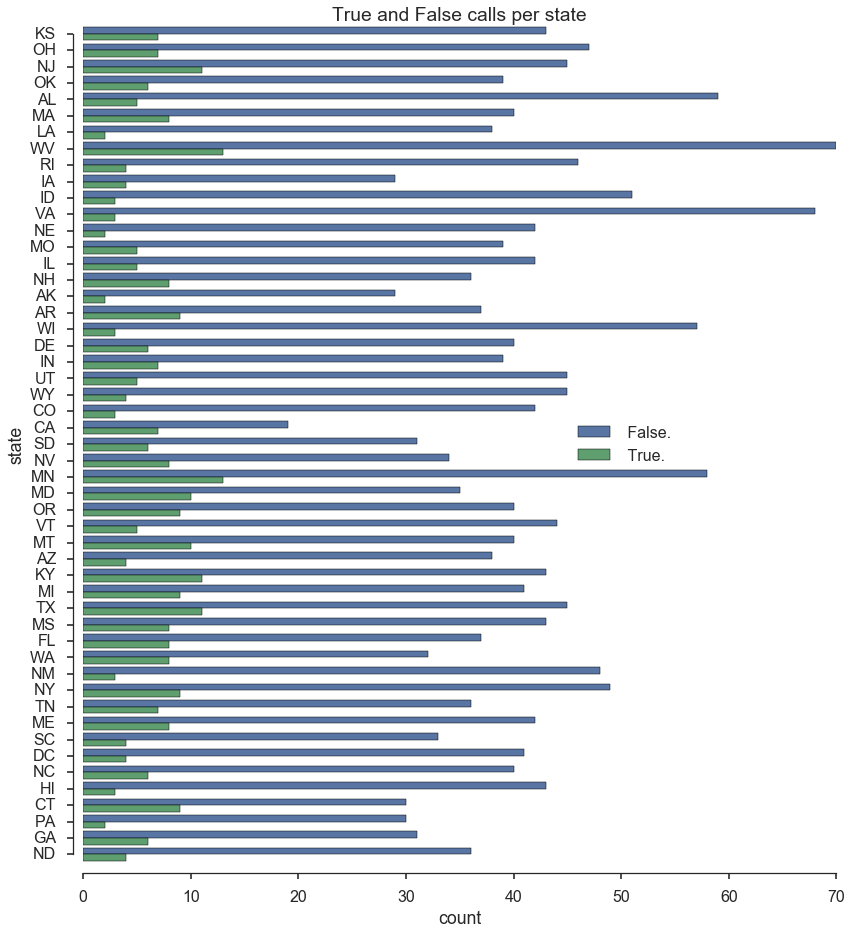

In [115]:
sb.set_style("white")
sb.set_style('ticks')

fig, ax = plt.subplots()
fig.set_size_inches(13.5, 15.0)

sb.countplot(y='state',hue=" churned", data=panda_df)
#ax.legend_.remove()
ax.legend(loc='center right', bbox_to_anchor=(0.8, 0.5), ncol=1)
sb.despine(offset=10, trim=True)
sb.plt.title('True and False calls per state')
sb.despine()

plt.show()

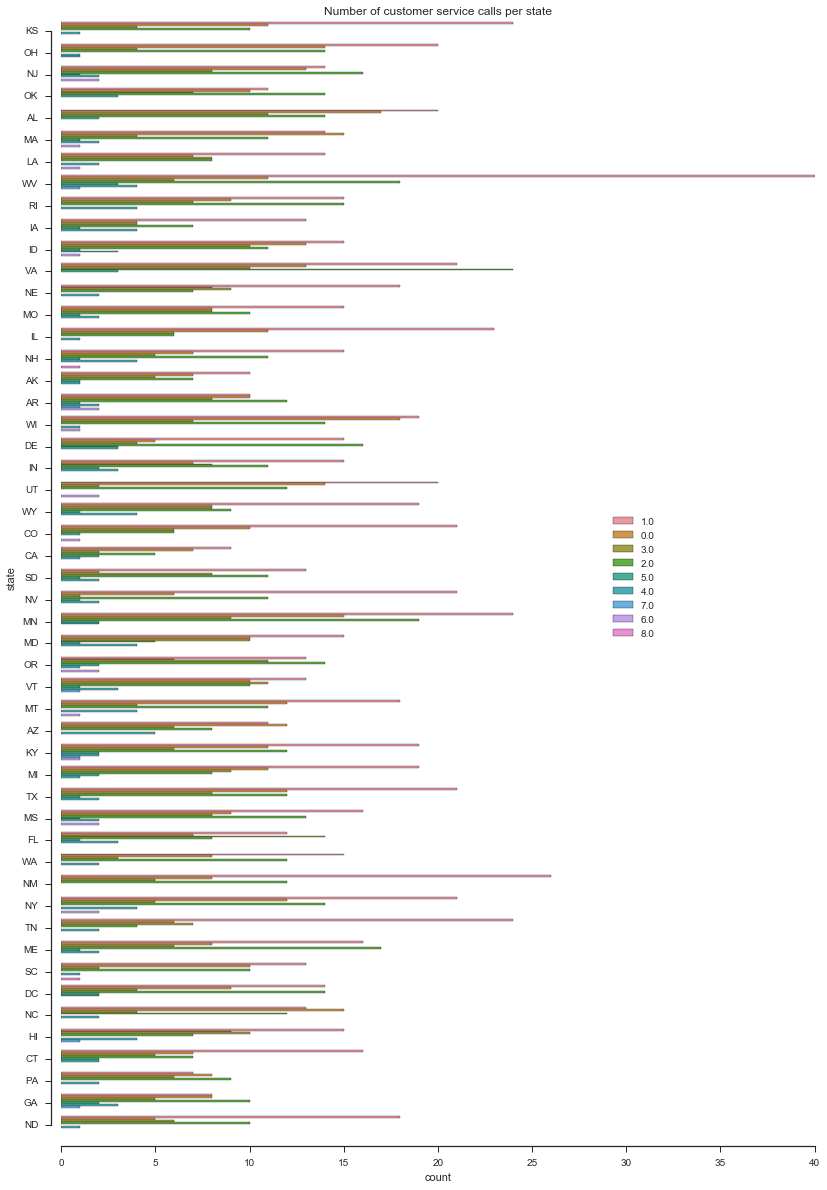

In [70]:
sb.set_style("white")
sb.set_style('ticks')

fig, ax = plt.subplots()
fig.set_size_inches(13.5, 20.0)

sb.countplot(y='state',hue=" number_customer_service_calls", data=panda_df)
#ax.legend_.remove()
ax.legend(loc='center right', bbox_to_anchor=(0.8, 0.5), ncol=1)
sb.despine(offset=10, trim=True)
sb.plt.title('Number of customer service calls per state')
sb.despine()

plt.show()

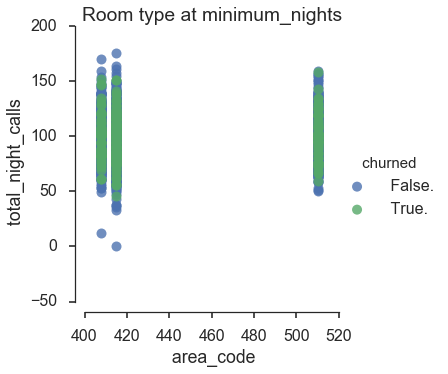

In [100]:

sb.lmplot(' area_code', ' total_night_calls',
           data=panda_df,
           fit_reg=False,
           hue=" churned",  
           scatter_kws={"marker": "D",
                        "s": 100})
#ax.legend_.remove()
ax.legend(loc='center right', bbox_to_anchor=(0.8, 0.5), ncol=1)
sb.despine(offset=10, trim=True)
sb.plt.title('Room type at minimum_nights')
sb.despine()

plt.show()

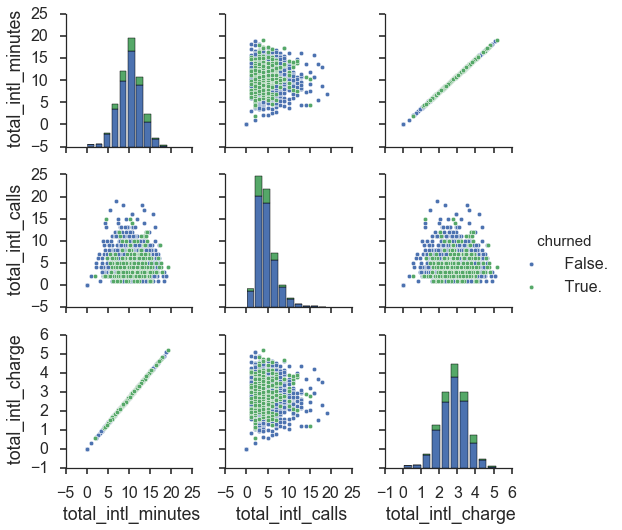

In [101]:
example_numeric_data = panda_df[[" total_intl_minutes", " total_intl_calls",
                                       " total_intl_charge", " churned"]]
sb.pairplot(example_numeric_data, hue=" churned")

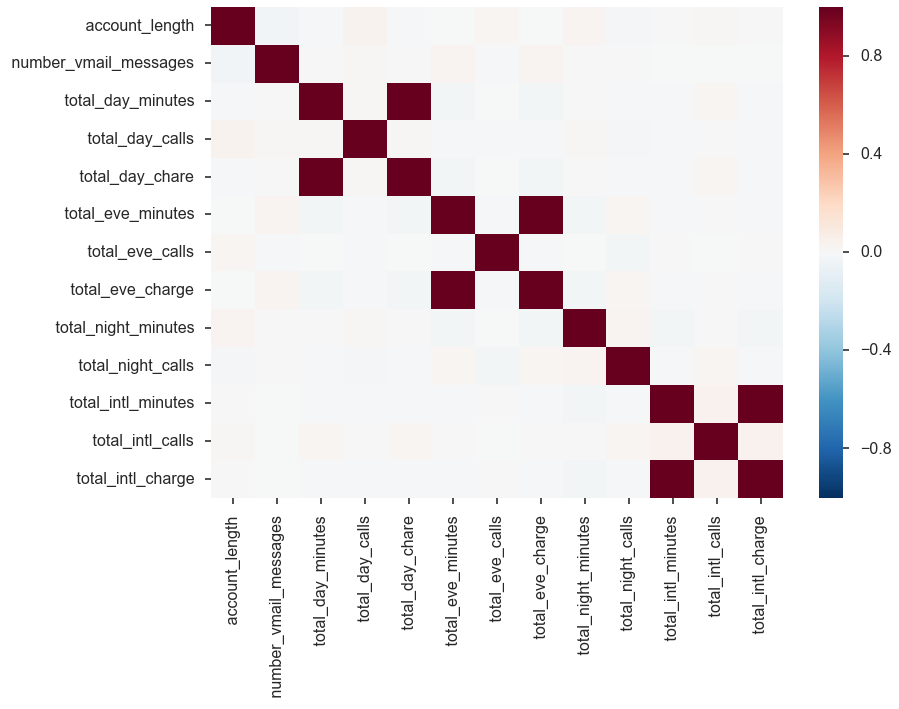

In [106]:
corr = panda_df[[" account_length", " number_vmail_messages", " total_day_minutes",
                    " total_day_calls", " total_day_chare", " total_eve_minutes",
                    " total_eve_calls", " total_eve_charge", " total_night_minutes",
                    " total_night_calls", " total_intl_minutes", " total_intl_calls",
                    " total_intl_charge"]].corr()

sb.heatmap(corr)

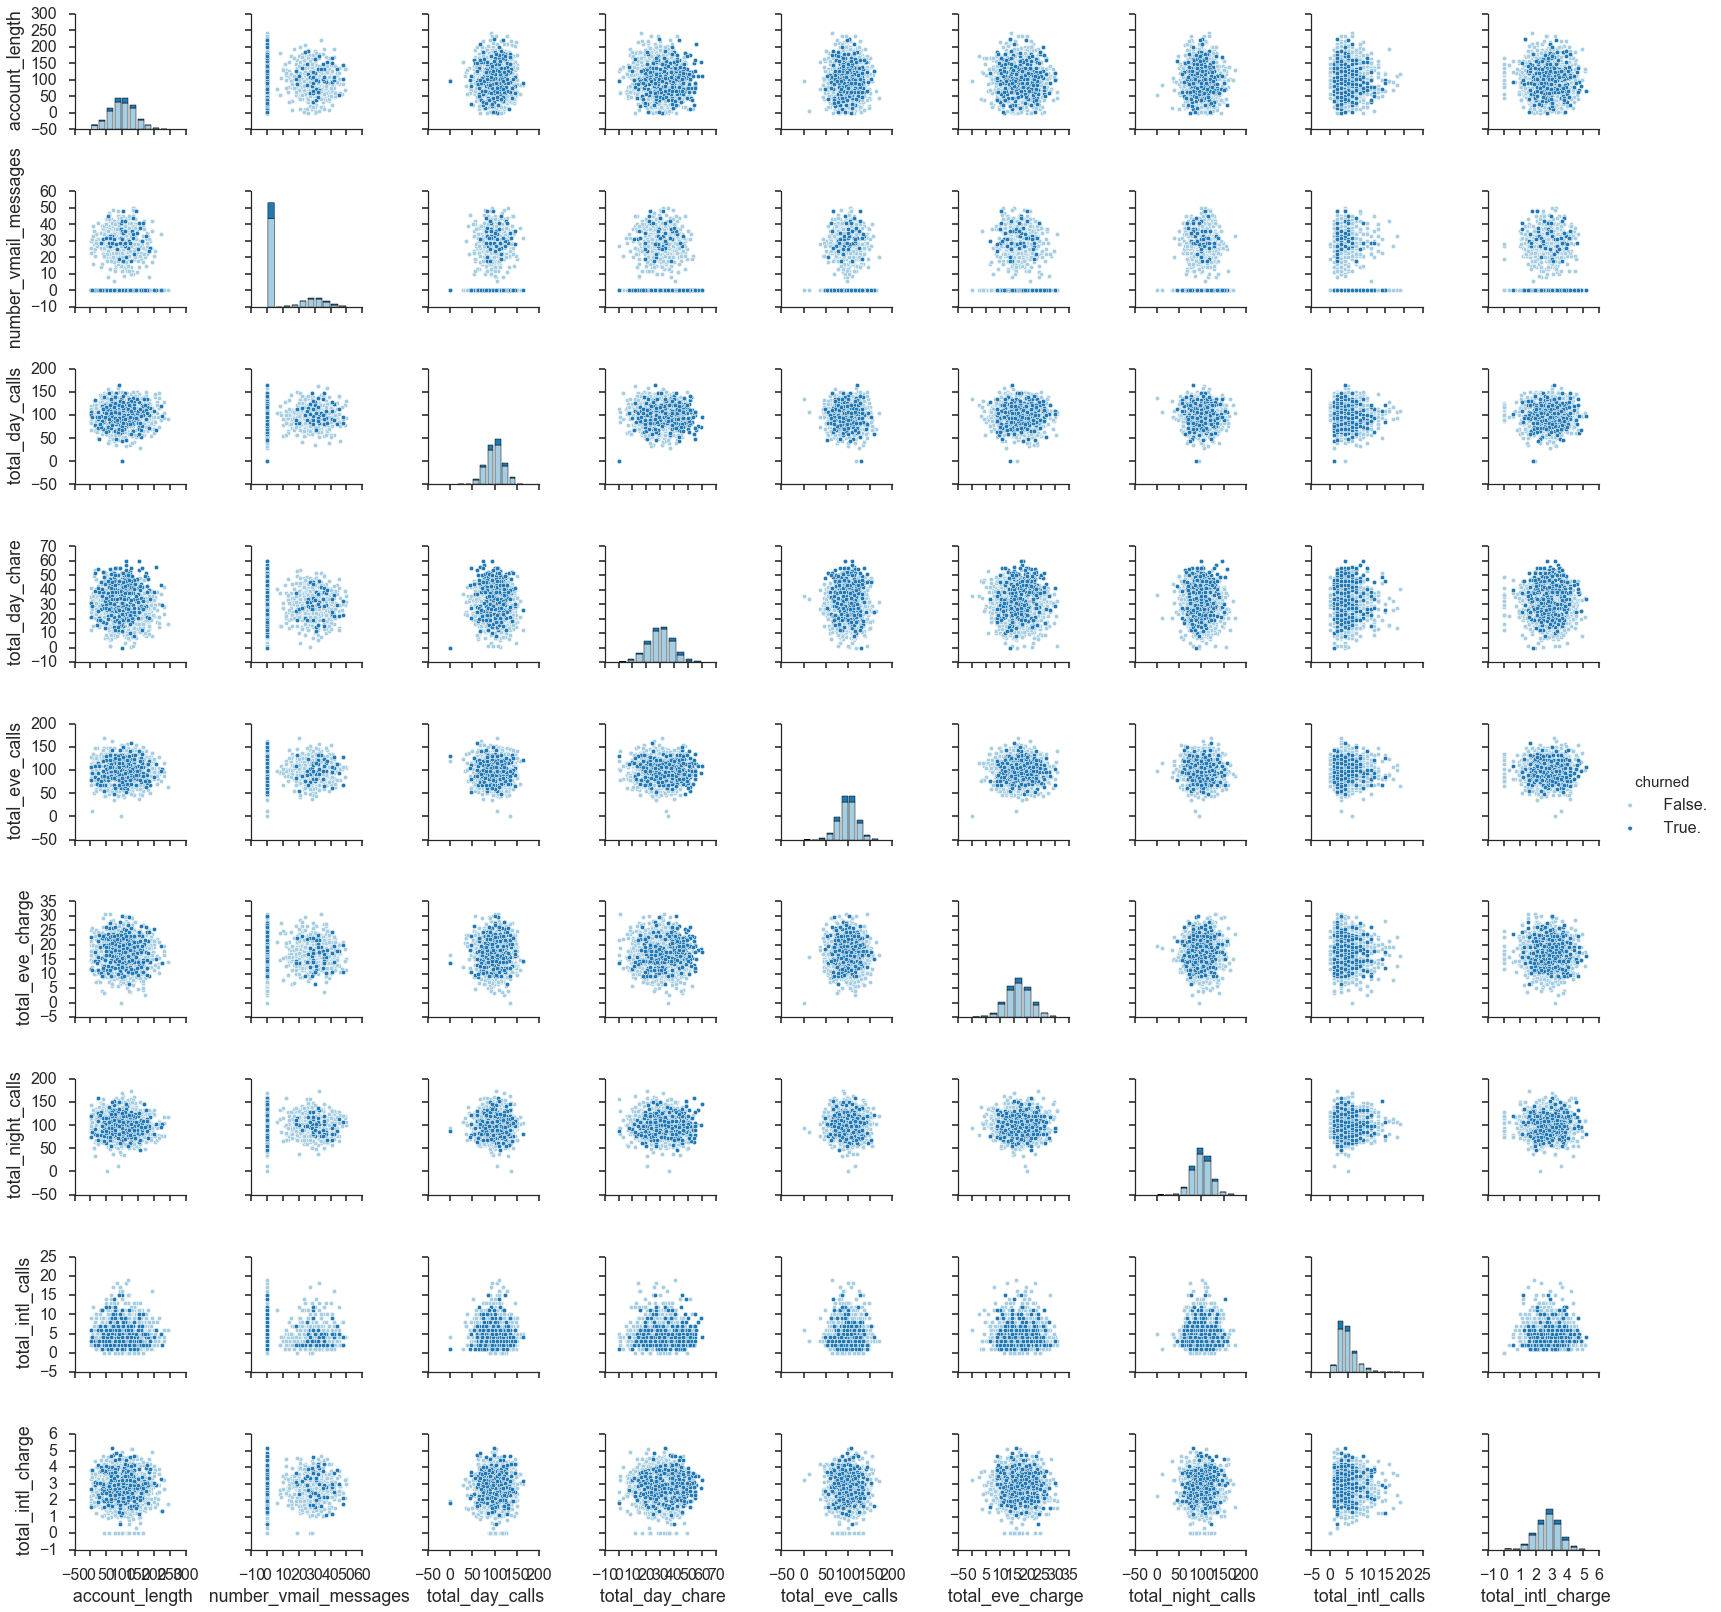

In [108]:
reduced_numeric_cols = [" account_length", " number_vmail_messages", " total_day_calls",
                        " total_day_chare", " total_eve_calls", " total_eve_charge",
                        " total_night_calls", " total_intl_calls", " total_intl_charge"]

sb.pairplot(panda_df[reduced_numeric_cols + [' churned']], hue=" churned", palette='Paired')

#### to be continued ...